In [115]:
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import keras
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.optimizers import Adam
from keras import regularizers

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

from get_labeled_dfs import *
from process_text import *

In [2]:
# getting data
corpus_df, val_corpus_df, emotion_df, val_emotion_df, valence_df, val_valence_df = get_labeled_dfs()


In [3]:
# using custom class method to process data
processor = Process_Text_Data()
processor.transform(corpus_df)


In [4]:
corpus_df.head()


,text
0,test predict breast cancer relapse approve
1,two hussein ally hang iraqi official say
2,sight sound ces
3,schuey see ferrari unveil new car
4,closing cancellation top advice flu outbreak


In [5]:
valence_df.head()

,valence,label
0,32,1
1,-48,0
2,26,1
3,40,1
4,-6,2


# Exploratory Data Analysis

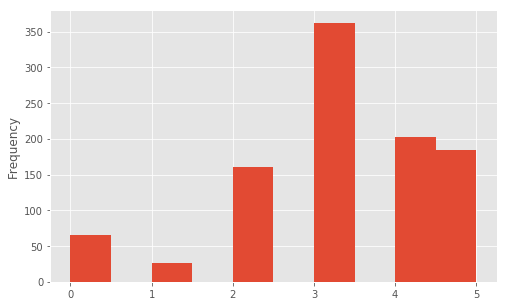

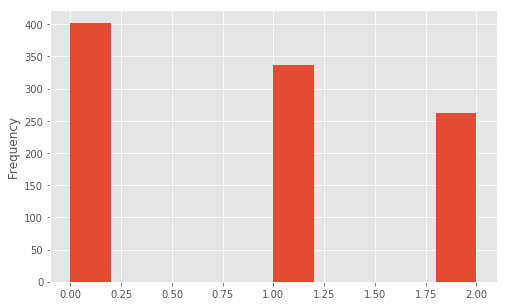

In [6]:
# distribution of classes
plt.figure(figsize=(8,5))
emotion_df['label'].plot(kind='hist')
plt.figure(figsize=(8,5))
valence_df['label'].plot(kind='hist')
plt.show()

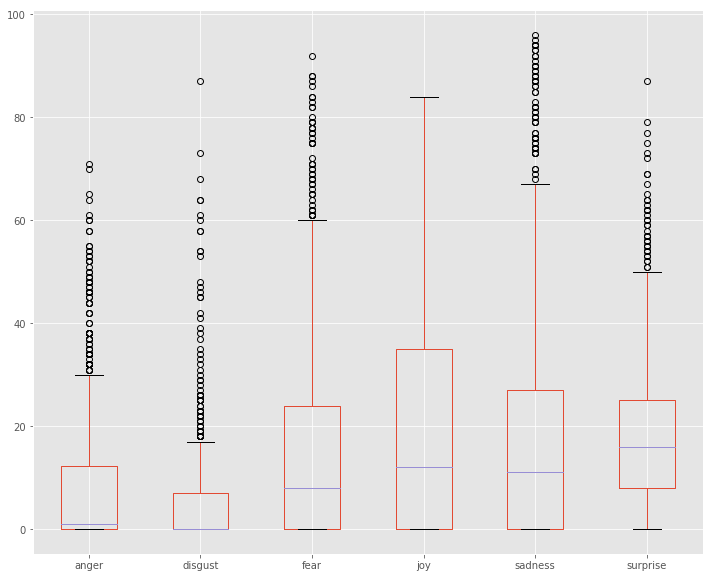

In [7]:
# boxplot showing the disribution of scores for each emotion category
plt.figure(figsize=(12,10))
emotion_df.iloc[:,:-1].boxplot()

In [8]:
# there are no entries with rating 0. for all emotion categories, but there are entries with very small values across the board
emotion_df.loc[(emotion_df.anger==0)&(emotion_df.disgust==0)&(emotion_df.fear==0)&(emotion_df.joy==0)&(emotion_df.sadness==0)& (emotion_df.surprise==0)]
emotion_df.loc[(emotion_df.anger + emotion_df.disgust + emotion_df.fear + emotion_df.joy + emotion_df.sadness + emotion_df.surprise)<15]


,anger,disgust,fear,joy,sadness,surprise,max,label
20,2,2,0,0,0,10,surprise,5
73,0,0,0,0,0,14,surprise,5
98,0,0,9,0,3,2,fear,2
200,0,0,5,1,1,6,surprise,5
217,4,0,4,0,3,0,anger,0
231,0,0,0,2,0,0,joy,3
375,0,0,0,9,0,2,joy,3
480,0,0,0,3,0,11,surprise,5
536,0,0,0,5,0,2,joy,3
640,0,0,0,2,0,1,joy,3


In [9]:
# creating another neutral/low_emotion category to separate especially low values
# total = (emotion_df.anger + emotion_df.disgust + emotion_df.fear + emotion_df.joy + emotion_df.sadness + emotion_df.surprise)

# old_labels = [i for i in emotion_df.label]
# new_label_list = []

# for i,v in enumerate(total):
#     if total[i] <= 15:
#         new_label_list.append(7)
#     else:
#         new_label_list.append(old_labels[i])

# emotion_df['new_label'] = new_label_list

In [10]:
# emotion_df.new_label.value_counts()

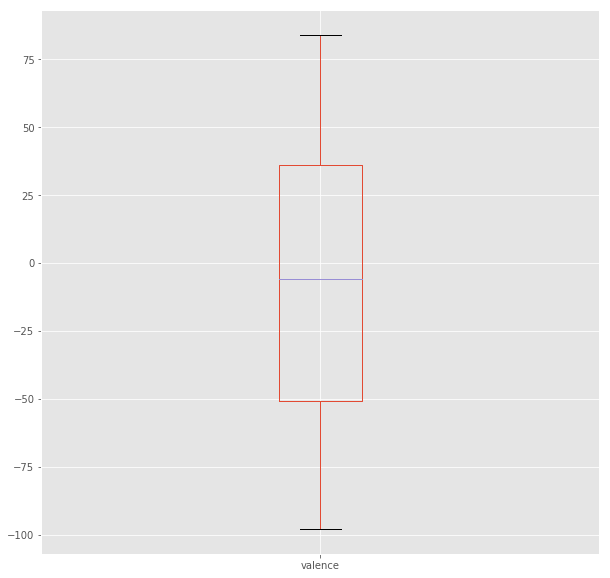

In [11]:
# boxplot showing the disribution of valencescores 
plt.figure(figsize=(10,10))
valence_df['valence'].plot(kind='box')

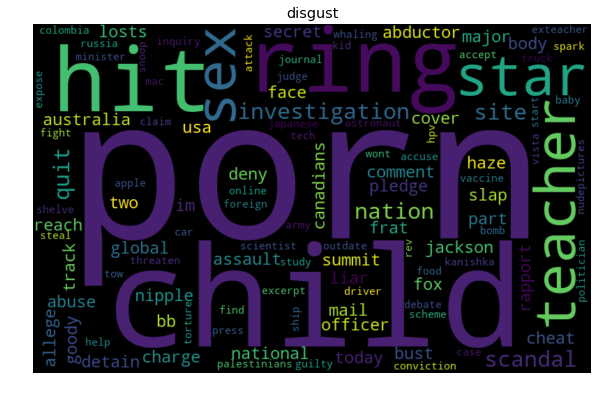

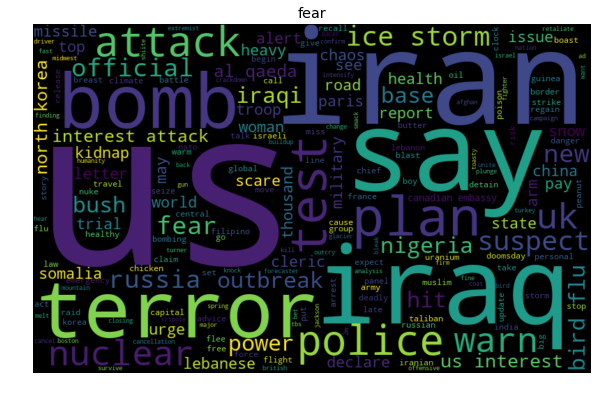

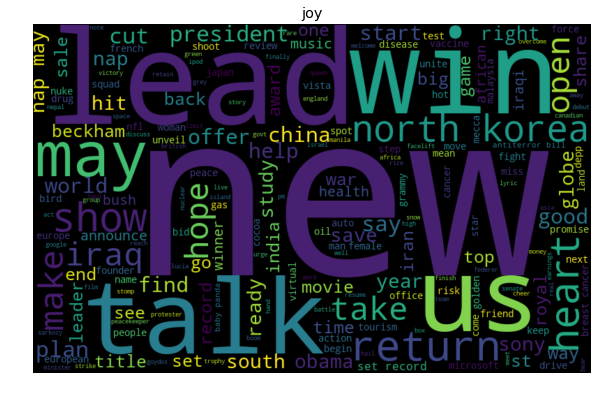

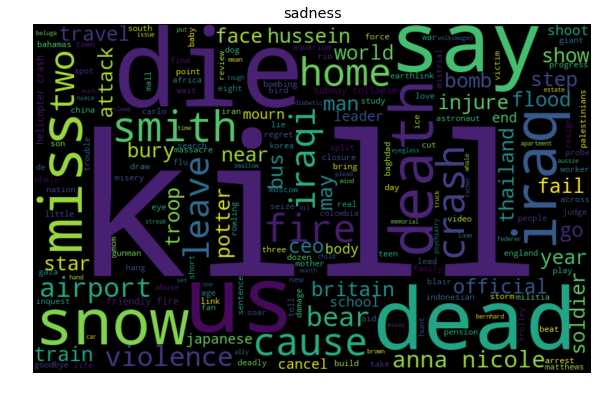

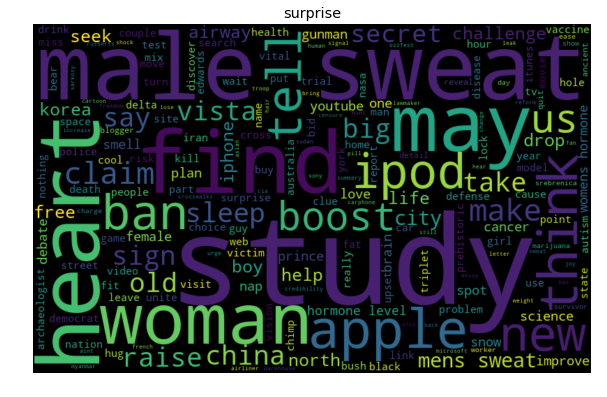

In [12]:
for i in list(emotion_df.columns[1:-2]):
    
    indexes = []
    for index, val in enumerate(emotion_df['max']):
        if val==i:
            indexes.append(index)
    
    single_emotion = corpus_df['text'][indexes] 
    word_string =' '.join([i for i in single_emotion])

    wordcloud = WordCloud(width=800, height=500, random_state=42).generate(word_string)
    plt.figure(figsize=(10, 7))
    plt.title(i)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()
    

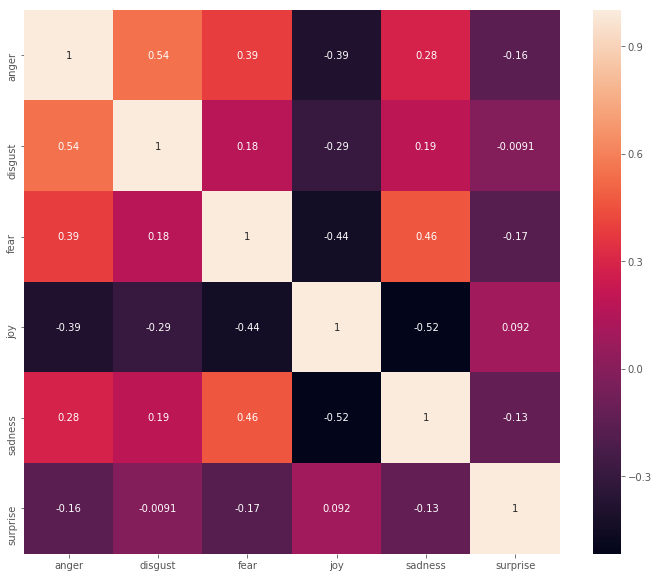

In [13]:
# correlations among emotion categories
plt.figure(figsize=(12,10))
corr = emotion_df.iloc[:,:-1].corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True)

# Models

## Strong Pos/Neg Valence only

In [20]:
y = valence_df['label'].loc[(valence_df['label']==1)|(valence_df['label']==0)]
X = corpus_df['text'].iloc[y.index]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1)

In [21]:
vectorizer = TfidfVectorizer()
tf_idf_X_train = vectorizer.fit_transform(X_train)
tf_idf_X_test = vectorizer.transform(X_test)
tf_idf_X_train.shape

(553, 1615)

In [22]:
smt = SMOTE(sampling_strategy='not majority')
X_res, y_res = smt.fit_resample(tf_idf_X_train, y_train)
X_res.shape


(602, 1615)

In [23]:
nb_classifier = MultinomialNB()
rf_classifier = RandomForestClassifier(max_depth=25)
knn_classifier = KNeighborsClassifier(n_neighbors=5)
lr_classifier = LogisticRegression(C=1e10)

nb_classifier.fit(X_res, y_res)
nb_train_preds = nb_classifier.predict(X_res)
nb_test_preds = nb_classifier.predict(tf_idf_X_test)

rf_classifier.fit(X_res, y_res)
rf_train_preds = rf_classifier.predict(X_res)
rf_test_preds = rf_classifier.predict(tf_idf_X_test)

knn_classifier.fit(X_res, y_res)
knn_train_preds = knn_classifier.predict(X_res)
knn_test_preds = knn_classifier.predict(tf_idf_X_test)

lr_classifier.fit(X_res, y_res)
lr_train_preds = lr_classifier.predict(X_res)
lr_test_preds = lr_classifier.predict(tf_idf_X_test)

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Multinomial Naive Bayes
Training Accuracy: 0.9850498338870431
Training F1: 0.985049792634167
Testing Accuracy: 0.8162162162162162
Testing F1: 0.8157592591407414


Random Forest
Training Accuracy: 0.8571428571428571
Training F1: 0.985049792634167
Testing Accuracy: 0.6918918918918919
Testing F1: 0.6805557578390432


K Nearest Neighbors
Training Accuracy: 0.5930232558139535
Training F1: 0.5153504664451914
Testing Accuracy: 0.5891891891891892
Testing F1: 0.5535940909853952


Logistic Regression
Training Accuracy: 1.0
Training F1: 1.0
Testing Accuracy: 0.7837837837837838
Testing F1: 0.7832461872244018


Text(373.36363636363626, 0.5, 'Predicted')

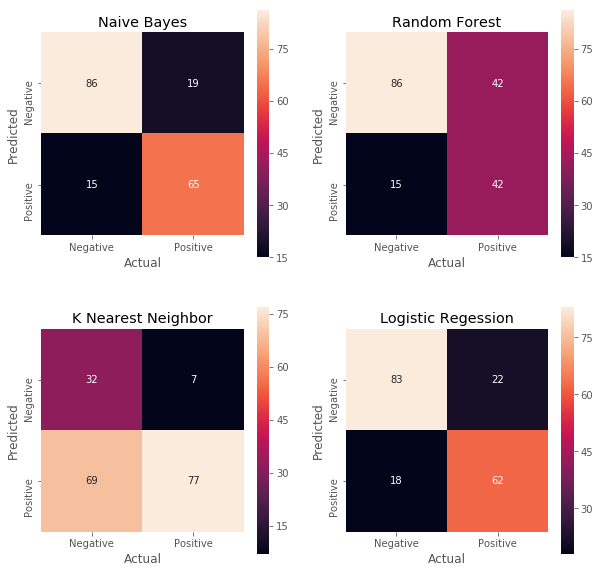

In [38]:
nb_train_acc = accuracy_score(y_res, nb_train_preds)
nb_test_acc = accuracy_score(y_test, nb_test_preds)
nb_train_f1 = f1_score(y_res, nb_train_preds, average='weighted')
nb_test_f1 = f1_score(y_test, nb_test_preds, average='weighted')
rf_train_acc = accuracy_score(y_res, rf_train_preds)
rf_test_acc = accuracy_score(y_test, rf_test_preds)
rf_train_f1 = f1_score(y_res, rf_train_preds, average='weighted')
rf_test_f1 = f1_score(y_test, rf_test_preds, average='weighted')
knn_train_acc = accuracy_score(y_res, knn_train_preds)
knn_test_acc = accuracy_score(y_test, knn_test_preds)
knn_train_f1 = f1_score(y_res, knn_train_preds, average='weighted')
knn_test_f1 = f1_score(y_test, knn_test_preds, average='weighted')
lr_train_acc = accuracy_score(y_res, lr_train_preds)
lr_test_acc = accuracy_score(y_test, lr_test_preds)
lr_train_f1 = f1_score(y_res, lr_train_preds, average='weighted')
lr_test_f1 = f1_score(y_test, lr_test_preds, average='weighted')

# note that the the high negative class is being treated as the target 

print("Multinomial Naive Bayes")
print("Training Accuracy:", nb_train_acc)
print("Training F1:", nb_train_f1)
print("Testing Accuracy:", nb_test_acc)
print("Testing F1:", nb_test_f1)
print("\n")
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
cm = confusion_matrix(y_test, nb_test_preds)
sns.heatmap(cm.T, square=True, annot=True, yticklabels=['Negative', 'Positive'], xticklabels=['Negative', 'Positive', ])
plt.title('Naive Bayes')
plt.xlabel('Actual')
plt.ylabel('Predicted')

print('Random Forest')
print("Training Accuracy:", rf_train_acc)
print("Training F1:", nb_train_f1)
print("Testing Accuracy:", rf_test_acc)
print("Testing F1:", rf_test_f1)
print("\n")
plt.subplot(2,2,2)
cm = confusion_matrix(y_test, rf_test_preds)
sns.heatmap(cm.T, square=True, annot=True, yticklabels=['Negative', 'Positive'], xticklabels=['Negative', 'Positive', ])
plt.title('Random Forest')
plt.xlabel('Actual')
plt.ylabel('Predicted')

print('K Nearest Neighbors')
print("Training Accuracy:", knn_train_acc)
print("Training F1:", knn_train_f1)
print("Testing Accuracy:", knn_test_acc)
print("Testing F1:", knn_test_f1)
print("\n")
plt.subplot(2,2,3)
cm = confusion_matrix(y_test, knn_test_preds)
sns.heatmap(cm.T, square=True, annot=True, yticklabels=['Negative', 'Positive'], xticklabels=['Negative', 'Positive'])
plt.title('K Nearest Neighbor')
plt.xlabel('Actual')
plt.ylabel('Predicted')

print('Logistic Regression')
print("Training Accuracy:", lr_train_acc)
print("Training F1:", lr_train_f1)
print("Testing Accuracy:", lr_test_acc)
print("Testing F1:", lr_test_f1)
plt.subplot(2,2,4)
cm = confusion_matrix(y_test, lr_test_preds)
sns.heatmap(cm.T, square=True, annot=True, yticklabels=['Negative', 'Positive'], xticklabels=['Negative', 'Positive'])
plt.title('Logistic Regession')
plt.xlabel('Actual')
plt.ylabel('Predicted')

In [45]:
df = pd.DataFrame({"true": y_test, "predicted":lr_test_preds})
len(df.loc[(df.true==0) & (df.predicted==1)])

18

## All valence labels

In [46]:
X = corpus_df['text']
y = valence_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1)


In [47]:
vectorizer = TfidfVectorizer()
tf_idf_X_train = vectorizer.fit_transform(X_train)
tf_idf_X_test = vectorizer.transform(X_test)
tf_idf_X_train.shape


(750, 2020)

In [48]:
smt = SMOTE(sampling_strategy='not majority')
X_res, y_res = smt.fit_resample(tf_idf_X_train, y_train)
X_res.shape


(906, 2020)

In [49]:
nb_classifier = MultinomialNB()
rf_classifier = RandomForestClassifier(max_depth=25)
knn_classifier = KNeighborsClassifier(n_neighbors=5)
lr_classifier = LogisticRegression(C=1e10)

nb_classifier.fit(X_res, y_res)
nb_train_preds = nb_classifier.predict(X_res)
nb_test_preds = nb_classifier.predict(tf_idf_X_test)

rf_classifier.fit(X_res, y_res)
rf_train_preds = rf_classifier.predict(X_res)
rf_test_preds = rf_classifier.predict(tf_idf_X_test)

knn_classifier.fit(X_res, y_res)
knn_train_preds = knn_classifier.predict(X_res)
knn_test_preds = knn_classifier.predict(tf_idf_X_test)

lr_classifier.fit(X_res, y_res)
lr_train_preds = lr_classifier.predict(X_res)
lr_test_preds = lr_classifier.predict(tf_idf_X_test)

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Multinomial Naive Bayes
Training Accuracy: 0.9713024282560706
Training F1: 0.9713058773699861
Testing Accuracy: 0.58
Testing F1: 0.5793464488434072


Random Forest
Training Accuracy: 0.7406181015452539
Training F1: 0.9713058773699861
Testing Accuracy: 0.492
Testing F1: 0.4559935587761675


K Nearest Neighbors
Training Accuracy: 0.5562913907284768
Training F1: 0.5252240143369176
Testing Accuracy: 0.416
Testing F1: 0.4079180364163835


Logistic Regression
Training Accuracy: 0.9988962472406181
Training F1: 0.9988962442151044
Testing Accuracy: 0.604
Testing F1: 0.602647127878028


Text(373.36363636363626, 0.5, 'Predicted')

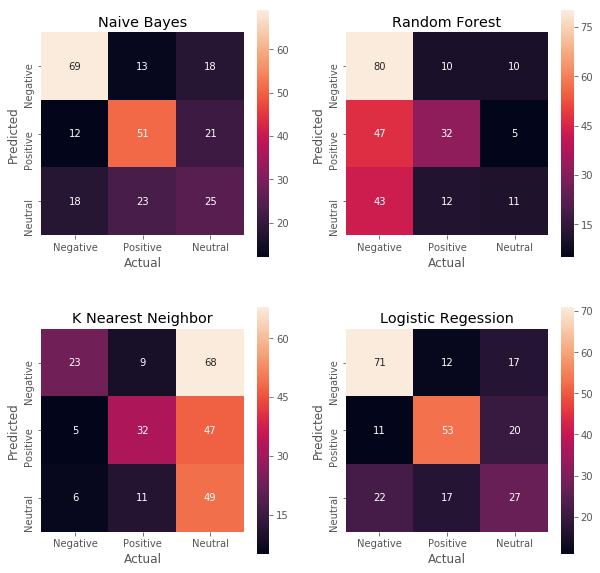

In [62]:
nb_train_acc = accuracy_score(y_res, nb_train_preds)
nb_test_acc = accuracy_score(y_test, nb_test_preds)
nb_train_f1 = f1_score(y_res, nb_train_preds, average='weighted')
nb_test_f1 = f1_score(y_test, nb_test_preds, average='weighted')
rf_train_acc = accuracy_score(y_res, rf_train_preds)
rf_test_acc = accuracy_score(y_test, rf_test_preds)
rf_train_f1 = f1_score(y_res, rf_train_preds, average='weighted')
rf_test_f1 = f1_score(y_test, rf_test_preds, average='weighted')
knn_train_acc = accuracy_score(y_res, knn_train_preds)
knn_test_acc = accuracy_score(y_test, knn_test_preds)
knn_train_f1 = f1_score(y_res, knn_train_preds, average='weighted')
knn_test_f1 = f1_score(y_test, knn_test_preds, average='weighted')
lr_train_acc = accuracy_score(y_res, lr_train_preds)
lr_test_acc = accuracy_score(y_test, lr_test_preds)
lr_train_f1 = f1_score(y_res, lr_train_preds, average='weighted')
lr_test_f1 = f1_score(y_test, lr_test_preds, average='weighted')

# note that the the high negative class is being treated as the target 

print("Multinomial Naive Bayes")
print("Training Accuracy:", nb_train_acc)
print("Training F1:", nb_train_f1)
print("Testing Accuracy:", nb_test_acc)
print("Testing F1:", nb_test_f1)
print("\n")
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
cm = confusion_matrix(y_test, nb_test_preds)
sns.heatmap(cm, square=True, annot=True, yticklabels=['Negative', 'Positive', 'Neutral'], xticklabels=['Negative', 'Positive', 'Neutral'])
plt.title('Naive Bayes')
plt.xlabel('Actual')
plt.ylabel('Predicted')

print('Random Forest')
print("Training Accuracy:", rf_train_acc)
print("Training F1:", nb_train_f1)
print("Testing Accuracy:", rf_test_acc)
print("Testing F1:", rf_test_f1)
print("\n")
plt.subplot(2,2,2)
cm = confusion_matrix(y_test, rf_test_preds)
sns.heatmap(cm, square=True, annot=True, yticklabels=['Negative', 'Positive', 'Neutral'], xticklabels=['Negative', 'Positive', 'Neutral'])
plt.title('Random Forest')
plt.xlabel('Actual')
plt.ylabel('Predicted')

print('K Nearest Neighbors')
print("Training Accuracy:", knn_train_acc)
print("Training F1:", knn_train_f1)
print("Testing Accuracy:", knn_test_acc)
print("Testing F1:", knn_test_f1)
print("\n")
plt.subplot(2,2,3)
cm = confusion_matrix(y_test, knn_test_preds)
sns.heatmap(cm, square=True, annot=True, yticklabels=['Negative', 'Positive', 'Neutral'], xticklabels=['Negative', 'Positive', 'Neutral'])
plt.title('K Nearest Neighbor')
plt.xlabel('Actual')
plt.ylabel('Predicted')

print('Logistic Regression')
print("Training Accuracy:", lr_train_acc)
print("Training F1:", lr_train_f1)
print("Testing Accuracy:", lr_test_acc)
print("Testing F1:", lr_test_f1)
plt.subplot(2,2,4)
cm = confusion_matrix(y_test, lr_test_preds)
sns.heatmap(cm, square=True, annot=True, yticklabels=['Negative', 'Positive', 'Neutral'], xticklabels=['Negative', 'Positive', 'Neutral'])
plt.title('Logistic Regession')
plt.xlabel('Actual')
plt.ylabel('Predicted')

In [67]:
df = pd.DataFrame({"true": y_test, "predicted":knn_test_preds})
len(df.loc[(df.true==2) & (df.predicted==2)])

49

## Emotion categories

In [68]:
X = corpus_df['text']
y = emotion_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1)


In [69]:
vectorizer = TfidfVectorizer()
tf_idf_X_train = vectorizer.fit_transform(X_train)
tf_idf_X_test = vectorizer.transform(X_test)
tf_idf_X_train.shape


(750, 2005)

In [70]:
smt = SMOTE(sampling_strategy='not majority')
X_res, y_res = smt.fit_resample(tf_idf_X_train, y_train)
X_res.shape


(1632, 2005)

In [71]:
nb_classifier = MultinomialNB()
rf_classifier = RandomForestClassifier(max_depth=25)
knn_classifier = KNeighborsClassifier(n_neighbors=5)
lr_classifier = LogisticRegression(C=1e10)

nb_classifier.fit(X_res, y_res)
nb_train_preds = nb_classifier.predict(X_res)
nb_test_preds = nb_classifier.predict(tf_idf_X_test)

rf_classifier.fit(X_res, y_res)
rf_train_preds = rf_classifier.predict(X_res)
rf_test_preds = rf_classifier.predict(tf_idf_X_test)

knn_classifier.fit(X_res, y_res)
knn_train_preds = knn_classifier.predict(X_res)
knn_test_preds = knn_classifier.predict(tf_idf_X_test)

lr_classifier.fit(X_res, y_res)
lr_train_preds = lr_classifier.predict(X_res)
lr_test_preds = lr_classifier.predict(tf_idf_X_test)

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Multinomial Naive Bayes
Training Accuracy: 0.960171568627451
Training F1: 0.9597357387595243
Testing Accuracy: 0.44
Testing F1: 0.4474472277296851


Random Forest
Training Accuracy: 0.7830882352941176
Training F1: 0.9597357387595243
Testing Accuracy: 0.46
Testing F1: 0.42698707483820914


K Nearest Neighbors
Training Accuracy: 0.7873774509803921
Training F1: 0.75051051187243
Testing Accuracy: 0.36
Testing F1: 0.3509965648952717


Logistic Regression
Training Accuracy: 0.9993872549019608
Training F1: 0.9993872528314213
Testing Accuracy: 0.512
Testing F1: 0.5126184918723593


Text(373.36363636363626, 0.5, 'Predicted')

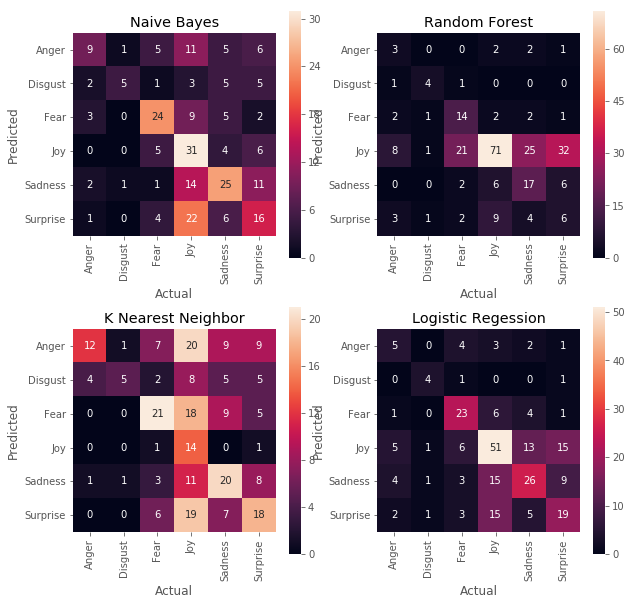

In [86]:
nb_train_acc = accuracy_score(y_res, nb_train_preds)
nb_test_acc = accuracy_score(y_test, nb_test_preds)
nb_train_f1 = f1_score(y_res, nb_train_preds, average='weighted')
nb_test_f1 = f1_score(y_test, nb_test_preds, average='weighted')
rf_train_acc = accuracy_score(y_res, rf_train_preds)
rf_test_acc = accuracy_score(y_test, rf_test_preds)
rf_train_f1 = f1_score(y_res, rf_train_preds, average='weighted')
rf_test_f1 = f1_score(y_test, rf_test_preds, average='weighted')
knn_train_acc = accuracy_score(y_res, knn_train_preds)
knn_test_acc = accuracy_score(y_test, knn_test_preds)
knn_train_f1 = f1_score(y_res, knn_train_preds, average='weighted')
knn_test_f1 = f1_score(y_test, knn_test_preds, average='weighted')
lr_train_acc = accuracy_score(y_res, lr_train_preds)
lr_test_acc = accuracy_score(y_test, lr_test_preds)
lr_train_f1 = f1_score(y_res, lr_train_preds, average='weighted')
lr_test_f1 = f1_score(y_test, lr_test_preds, average='weighted')

# note that the the high negative class is being treated as the target 

print("Multinomial Naive Bayes")
print("Training Accuracy:", nb_train_acc)
print("Training F1:", nb_train_f1)
print("Testing Accuracy:", nb_test_acc)
print("Testing F1:", nb_test_f1)
print("\n")
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
cm = confusion_matrix(y_test, nb_test_preds)
sns.heatmap(cm.T, square=True, annot=True, yticklabels=['Anger', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise'], xticklabels=['Anger', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise'])
plt.title('Naive Bayes')
plt.xlabel('Actual')
plt.ylabel('Predicted')

print('Random Forest')
print("Training Accuracy:", rf_train_acc)
print("Training F1:", nb_train_f1)
print("Testing Accuracy:", rf_test_acc)
print("Testing F1:", rf_test_f1)
print("\n")
plt.subplot(2,2,2)
cm = confusion_matrix(y_test, rf_test_preds)
sns.heatmap(cm.T, square=True, annot=True, yticklabels=['Anger', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise'], xticklabels=['Anger', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise'])
plt.title('Random Forest')
plt.xlabel('Actual')
plt.ylabel('Predicted')

print('K Nearest Neighbors')
print("Training Accuracy:", knn_train_acc)
print("Training F1:", knn_train_f1)
print("Testing Accuracy:", knn_test_acc)
print("Testing F1:", knn_test_f1)
print("\n")
plt.subplot(2,2,3)
cm = confusion_matrix(y_test, knn_test_preds)
sns.heatmap(cm.T, square=True, annot=True, yticklabels=['Anger', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise'], xticklabels=['Anger', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise'])
plt.title('K Nearest Neighbor')
plt.xlabel('Actual')
plt.ylabel('Predicted')

print('Logistic Regression')
print("Training Accuracy:", lr_train_acc)
print("Training F1:", lr_train_f1)
print("Testing Accuracy:", lr_test_acc)
print("Testing F1:", lr_test_f1)
plt.subplot(2,2,4)
cm = confusion_matrix(y_test, lr_test_preds)
sns.heatmap(cm.T, square=True, annot=True, yticklabels=['Anger', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise'], xticklabels=['Anger', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise'])
plt.title('Logistic Regession')
plt.xlabel('Actual')
plt.ylabel('Predicted')

In [87]:
df = pd.DataFrame({"true": y_test, "predicted":lr_test_preds})
len(df.loc[(df.true==4) & (df.predicted==3)])

13

## Neural Network: Strong Pos/Neg Valence 

In [159]:
y = valence_df['label'].loc[(valence_df['label']==1)|(valence_df['label']==0)]
X = corpus_df['text'].iloc[y.index]

# from keras.utils import to_categorical
# y_binary = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1)

vectorizer = TfidfVectorizer()
tf_idf_X_train = vectorizer.fit_transform(X_train)
tf_idf_X_test = vectorizer.transform(X_test)

smt = SMOTE(sampling_strategy='not majority')
X_res, y_res = smt.fit_resample(tf_idf_X_train, y_train)
y_res = pd.get_dummies(y_res).values

num_features = 1615
num_classes = 2

model = Sequential()
# first layer, includes input shape
model.add(Dense(300, activation='relu', input_shape=(num_features, )))
model.add(Dropout(0.5))
# second layer
model.add(Dense(150, activation='relu'))
model.add(Dropout(0.5))
# final layer with the number of classes as the number of outputs
# uses a softmax classifier, which is standard for NLP
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='mean_squared_error',
              optimizer=Adam(lr=.002, decay=.00001),
              metrics=['accuracy'])
              
history = model.fit(X_res, 
                    y_res,
                    epochs=50,
                    batch_size=100,
                    validation_data=(tf_idf_X_test, pd.get_dummies(y_test)))

Train on 602 samples, validate on 185 samples
Epoch 1/50
602/602 [==============================] - 2s 4ms/step - loss: 0.2491 - acc: 0.5199 - val_loss: 0.2450 - val_acc: 0.7784
Epoch 2/50
602/602 [==============================] - 0s 197us/step - loss: 0.2355 - acc: 0.7591 - val_loss: 0.2335 - val_acc: 0.6865
Epoch 3/50
602/602 [==============================] - 0s 193us/step - loss: 0.2101 - acc: 0.8040 - val_loss: 0.2080 - val_acc: 0.7243
Epoch 4/50
602/602 [==============================] - 0s 200us/step - loss: 0.1487 - acc: 0.9286 - val_loss: 0.1684 - val_acc: 0.8108
Epoch 5/50
602/602 [==============================] - 0s 213us/step - loss: 0.0728 - acc: 0.9867 - val_loss: 0.1410 - val_acc: 0.8270
Epoch 6/50
602/602 [==============================] - 0s 224us/step - loss: 0.0233 - acc: 0.9950 - val_loss: 0.1363 - val_acc: 0.8162
Epoch 7/50
602/602 [==============================] - 0s 218us/step - loss: 0.0081 - acc: 0.9950 - val_loss: 0.1431 - val_acc: 0.7838
Epoch 8/50
602/602

185/185 [==============================] - 0s 195us/step
[0.15440054825834326, 0.8162162178271526]


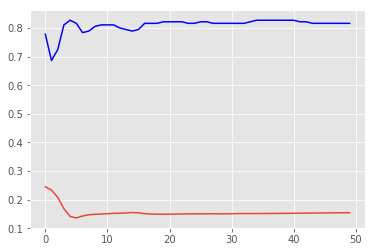

In [160]:
print(model.evaluate(tf_idf_X_test, pd.get_dummies(y_test)))

plt.plot(history.history['val_acc'], color='blue')
plt.plot(history.history['val_loss'])

## Neural Network: All Valence Labels

In [169]:
X = corpus_df['text']
y = valence_df['label']

from keras.utils import to_categorical
y_binary = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_binary, stratify=y, random_state=42)

vectorizer = TfidfVectorizer()
tf_idf_X_train = vectorizer.fit_transform(X_train)
tf_idf_X_test = vectorizer.transform(X_test)

smt = SMOTE(sampling_strategy='not majority')
X_res, y_res = smt.fit_resample(tf_idf_X_train, y_train)
X_res.shape

num_features = 2015
num_classes = 3

model = Sequential()
# first layer, includes input shape
model.add(Dense(300, activation='relu', input_shape=(num_features, )))
model.add(Dropout(0.2))
# second layer
model.add(Dense(150, activation='relu'))
model.add(Dropout(0.2))
# final layer with the number of classes as the number of outputs
# uses a softmax classifier, which is standard for NLP
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='mean_squared_error',
              optimizer=Adam(lr=.002, decay=.00001),
              metrics=['accuracy'])
              
history = model.fit(X_res, 
                    y_res,
                    epochs=50,
                    batch_size=100,
                    validation_data=(tf_idf_X_test, y_test))

Train on 903 samples, validate on 250 samples
Epoch 1/50
903/903 [==============================] - 3s 4ms/step - loss: 0.2200 - acc: 0.3765 - val_loss: 0.2174 - val_acc: 0.5080
Epoch 2/50
903/903 [==============================] - 0s 382us/step - loss: 0.1944 - acc: 0.7918 - val_loss: 0.2021 - val_acc: 0.5640
Epoch 3/50
903/903 [==============================] - 0s 292us/step - loss: 0.1178 - acc: 0.9579 - val_loss: 0.1828 - val_acc: 0.5880
Epoch 4/50
903/903 [==============================] - 0s 255us/step - loss: 0.0300 - acc: 0.9834 - val_loss: 0.1880 - val_acc: 0.5920
Epoch 5/50
903/903 [==============================] - 0s 218us/step - loss: 0.0063 - acc: 0.9922 - val_loss: 0.2009 - val_acc: 0.6000
Epoch 6/50
903/903 [==============================] - 0s 229us/step - loss: 0.0022 - acc: 0.9967 - val_loss: 0.2093 - val_acc: 0.6040
Epoch 7/50
903/903 [==============================] - 0s 288us/step - loss: 9.9801e-04 - acc: 0.9978 - val_loss: 0.2116 - val_acc: 0.6000
Epoch 8/50
903

250/250 [==============================] - 0s 163us/step
[0.2195097360610962, 0.5400000002384185]


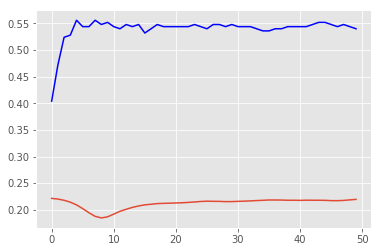

In [127]:
print(model.evaluate(tf_idf_X_test, y_test))

plt.plot(history.history['val_acc'], color='blue')
plt.plot(history.history['val_loss'])

## Neural Network: Emotion Labels

In [173]:
X = corpus_df['text']
y = emotion_df['label']

from keras.utils import to_categorical
y_binary = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_binary, stratify=y, random_state=42)

vectorizer = TfidfVectorizer()
tf_idf_X_train = vectorizer.fit_transform(X_train)
tf_idf_X_test = vectorizer.transform(X_test)

smt = SMOTE(sampling_strategy='not majority')
X_res, y_res = smt.fit_resample(tf_idf_X_train, y_train)
X_res.shape

num_features = 2050
num_classes = 6

model = Sequential()
# first layer, includes input shape
model.add(Dense(300, activation='relu', input_shape=(num_features, )))
model.add(Dropout(0.2))
# second layer
model.add(Dense(150, activation='relu'))
model.add(Dropout(0.2))
# final layer with the number of classes as the number of outputs
# uses a softmax classifier, which is standard for NLP
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='mean_squared_error',
              optimizer=Adam(lr=.002, decay=.00001),
              metrics=['accuracy'])
              
history = model.fit(X_res, 
                    y_res,
                    epochs=50,
                    batch_size=100,
                    validation_data=(tf_idf_X_test, y_test))

Train on 1626 samples, validate on 250 samples
Epoch 1/50
1626/1626 [==============================] - 4s 2ms/step - loss: 0.1332 - acc: 0.4902 - val_loss: 0.1333 - val_acc: 0.3800
Epoch 2/50
1626/1626 [==============================] - 1s 312us/step - loss: 0.0762 - acc: 0.8456 - val_loss: 0.1174 - val_acc: 0.3680
Epoch 3/50
1626/1626 [==============================] - 0s 206us/step - loss: 0.0182 - acc: 0.9625 - val_loss: 0.1133 - val_acc: 0.4920
Epoch 4/50
1626/1626 [==============================] - 0s 209us/step - loss: 0.0029 - acc: 0.9938 - val_loss: 0.1204 - val_acc: 0.4960
Epoch 5/50
1626/1626 [==============================] - 1s 319us/step - loss: 0.0010 - acc: 0.9969 - val_loss: 0.1226 - val_acc: 0.5080
Epoch 6/50
1626/1626 [==============================] - 0s 280us/step - loss: 7.5570e-04 - acc: 0.9975 - val_loss: 0.1235 - val_acc: 0.4960
Epoch 7/50
1626/1626 [==============================] - 0s 304us/step - loss: 8.3934e-04 - acc: 0.9975 - val_loss: 0.1236 - val_acc: 0.

250/250 [==============================] - 0s 182us/step
[0.13504040426015854, 0.48400000286102296]


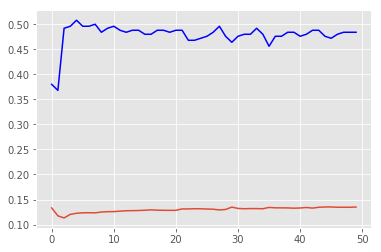

In [174]:
print(model.evaluate(tf_idf_X_test, y_test))

plt.plot(history.history['val_acc'], color='blue')
plt.plot(history.history['val_loss'])

## RNN w/ Word Embeddings: Valence Labels

In [175]:
# Trying Word Embeddings

## straight from Learn.co

data = corpus_df['text'].apply(lambda x: x.split())
total_vocabulary = set(word for headline in data for word in headline)

import numpy as np
glove = {}
with open('/Users/flatironschool/Desktop/glove/glove.6B.300d.txt', 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in total_vocabulary:
            vector = np.array(parts[1:], dtype=np.float32)
            glove[word] = vector

class W2vVectorizer(object):
    
    def __init__(self, w2v):
        # takes in a dictionary of words and vectors as input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(glove))])
    
    # Note from Mike: Even though it doesn't do anything, it's required that this object implement a fit method or else
    # It can't be used in a sklearn Pipeline. 
    def fit(self, X, y):
        return self
            
    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence

ind = valence_df['label'].loc[(valence_df['label']==1)|(valence_df['label']==2)].index
X = corpus_df['text'].iloc[ind]
y = pd.get_dummies(valence_df['label'].loc[(valence_df['label']==1)|(valence_df['label']==2)]).values

# X = corpus_df['text']
# y = pd.get_dummies(valence_df['label']).values

tokenizer = text.Tokenizer(num_words=20000)
tokenizer.fit_on_texts(list(X))
list_tokenized_headlines = tokenizer.texts_to_sequences(X)
X_t = sequence.pad_sequences(list_tokenized_headlines, maxlen=100)

embedding_size = 128
input_ = Input(shape=(100,))
x = Embedding(20000, embedding_size)(input_)
x = LSTM(25, return_sequences=True)(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.5)(x)
x = Dense(50, activation='relu')(x)
x = Dropout(0.5)(x)
# There are 2 different possible classes, so we use 41 neurons in our output layer
x = Dense(2, activation='softmax')(x)

model = Model(inputs=input_, outputs=x)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_t, y, epochs=15, batch_size=50, validation_split=0.1)




Train on 538 samples, validate on 60 samples
Epoch 1/15
538/538 [==============================] - 6s 11ms/step - loss: 0.6943 - acc: 0.4888 - val_loss: 0.6908 - val_acc: 0.5500
Epoch 2/15
538/538 [==============================] - 2s 3ms/step - loss: 0.6857 - acc: 0.5781 - val_loss: 0.6886 - val_acc: 0.5500
Epoch 3/15
538/538 [==============================] - 2s 3ms/step - loss: 0.6810 - acc: 0.5706 - val_loss: 0.6870 - val_acc: 0.5500
Epoch 4/15
538/538 [==============================] - 2s 3ms/step - loss: 0.6725 - acc: 0.5743 - val_loss: 0.6862 - val_acc: 0.5500
Epoch 5/15
538/538 [==============================] - 2s 4ms/step - loss: 0.6554 - acc: 0.6134 - val_loss: 0.6832 - val_acc: 0.5500
Epoch 6/15
538/538 [==============================] - 2s 4ms/step - loss: 0.6179 - acc: 0.7398 - val_loss: 0.6748 - val_acc: 0.5667
Epoch 7/15
538/538 [==============================] - 2s 4ms/step - loss: 0.5421 - acc: 0.8513 - val_loss: 0.6568 - val_acc: 0.6333
Epoch 8/15
538/538 [==========

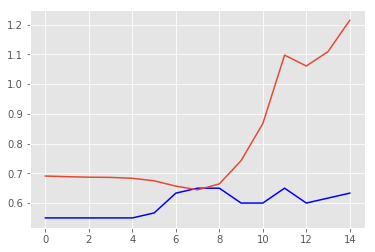

In [176]:
plt.plot(model.history.history['val_acc'], color='blue')
plt.plot(model.history.history['val_loss'])

## RNN: Emotion Labels

In [202]:
X = corpus_df['text']
y = emotion_df['label']

vectorizer = TfidfVectorizer()
tf_idf_X_train = vectorizer.fit_transform(X_train)
tf_idf_X_test = vectorizer.transform(X_test)

smt = SMOTE(sampling_strategy='not majority')
X_res, y_res = smt.fit_resample(tf_idf_X_train, y_train)
y_res = y_res

num_features = 2050   
num_classes = 6

model = Sequential()
# # first layer, includes input shape
model.add(LSTM(128, activation='relu', input_shape=(100, num_features, ), return_sequences=True))
model.add(Dropout(0.2))
# second layer
model.add(LSTM(128, activation='relu'))
model.add(Dropout(0.2))
# third layer
model.add(LSTM(32, activation='relu'))
model.add(Dropout(0.2))
# final layer with the number of classes as the number of outputs
# uses a softmax classifier, which is standard for NLP
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='mean_squared_error',
              optimizer=Adam(lr=.002, decay=.00001),
              metrics=['accuracy'])
              
history = model.fit(X_res, 
                    y_res,
                    epochs=50,
                    batch_size=100,
                    validation_data=(tf_idf_X_test, y_test))

ValueError: Input 0 is incompatible with layer lstm_29: expected ndim=3, found ndim=2

In [199]:
X_res

<1626x2050 sparse matrix of type '<class 'numpy.float64'>'
	with 12796 stored elements in Compressed Sparse Row format>